### Import TRPCA, load data, etc.

In [1]:
import pandas as pd
import torch
from TRPCA.utils import preprocess, train_model, predict_and_evaluate, analyze_features
from biom import load_table

In [2]:
# Load the filtered data later
df = pd.read_csv('data/wgs_skin_single_table.csv', index_col=0)
age_metadata = pd.read_csv('data/wgs_skin_single_metadata.csv', index_col=0)

[I 2025-02-13 12:54:34,631] A new study created in memory with name: no-name-4123723d-104f-4823-a1b0-7e05830ded36


Total number of unique groups (subjects): 62

Stratification distribution before splitting:
TettAJ_2016    0.403226
ChngKR_2016    0.322581
HMP_2012       0.274194
dtype: float64

Train split stratification distribution:
TettAJ_2016    0.400000
ChngKR_2016    0.327273
HMP_2012       0.272727
dtype: float64

Test split stratification distribution:
TettAJ_2016    0.428571
ChngKR_2016    0.285714
HMP_2012       0.285714
dtype: float64

Split Summary:
Groups in train: 55
Groups in test: 7
Samples in train: 55
Samples in test: 7
✓ Group integrity verified: No subject's samples are split between train and test


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-02-13 12:54:52,478] Trial 0 finished with value: 77.18399047851562 and parameters: {'lr': 0.07794976173508592, 'weight_decay': 0.00012931397787379123, 'optimizer': 'AdamW'}. Best is trial 0 with value: 77.18399047851562.


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-02-13 12:55:05,441] Trial 1 finished with value: 29.7650203704834 and parameters: {'lr': 0.04443589067627347, 'weight_decay': 0.0006456935339421866, 'optimizer': 'SGD'}. Best is trial 1 with value: 29.7650203704834.


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-02-13 12:55:22,281] Trial 2 finished with value: 1510.119873046875 and parameters: {'lr': 0.0006658464812478066, 'weight_decay': 0.024450220338311082, 'optimizer': 'AdamW'}. Best is trial 1 with value: 29.7650203704834.


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-02-13 12:55:37,269] Trial 3 finished with value: 1109.377685546875 and parameters: {'lr': 0.00014852209663590368, 'weight_decay': 0.00031380664325557714, 'optimizer': 'SGD'}. Best is trial 1 with value: 29.7650203704834.


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-02-13 12:55:56,638] Trial 4 finished with value: 847.7968139648438 and parameters: {'lr': 0.003952026407968312, 'weight_decay': 0.5684158695301904, 'optimizer': 'AdamW'}. Best is trial 1 with value: 29.7650203704834.


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Test Set Metrics:
MAE: 8.324
MSE: 120.049
RMSE: 10.957
R2: 0.575


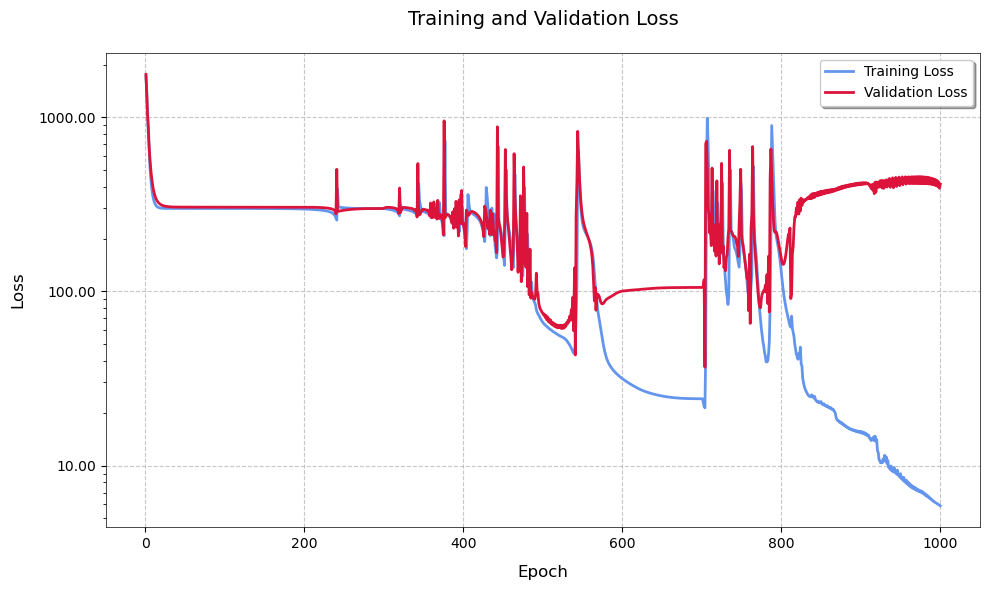

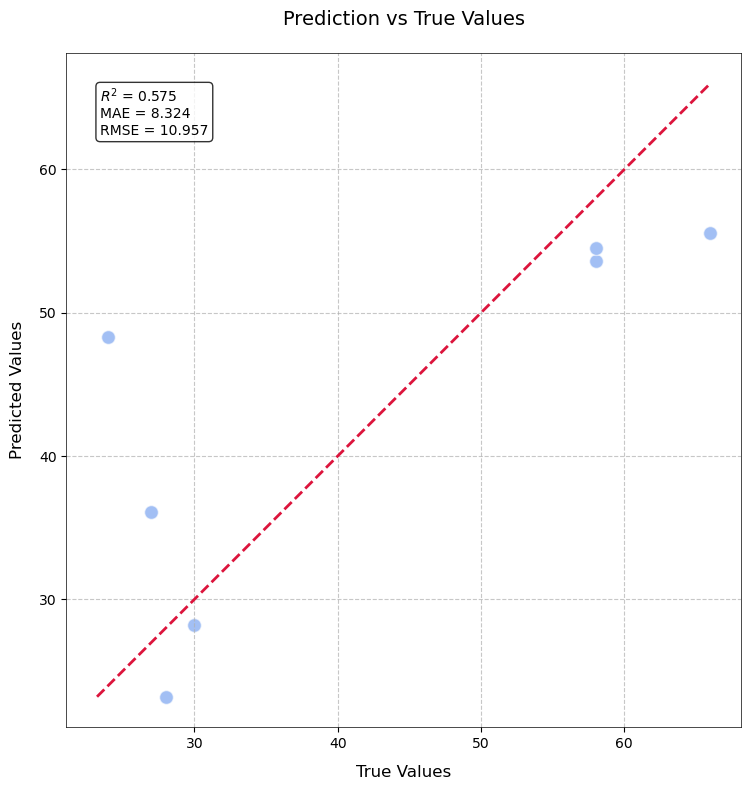

In [3]:
# Set up the features (X) and target (y)
X = df  # Your preprocessed feature table
y = age_metadata['age']  # The age values we want to predict

# Define model parameters
model_params = {
    'input_dim': 48,  
    'hidden_dim': 256,
    'num_layers': 1,
    'output_dim': 1,  
    'projection_dim': 4
}

# Preprocess with your parameters
train_loader, test_loader, pca, = preprocess(
    df=X,
    series=y,
    num_pcs=48,
    test_split=0.1,
    stratify_col=age_metadata['study_name'],
    group_col=age_metadata['subject_id'],
    batch_size=128,
)

# Train with your parameters
model, history, training_fig = train_model(
    train_loader=train_loader,
    model_params=model_params,
    num_epochs=1000,
    device='mps' if torch.backends.mps.is_available() else 'cpu',
    val_split=0.1,
    use_optuna=True, # True for parameter fine-tuning
    n_trials=5, # number of trials to run on the training data for exploration
)

# Evaluate
metrics, predictions, eval_fig = predict_and_evaluate(
    model=model,
    test_loader=test_loader,
    device='mps' if torch.backends.mps.is_available() else 'cpu',
)

PermutationExplainer explainer: 63it [00:39,  1.23it/s]                        


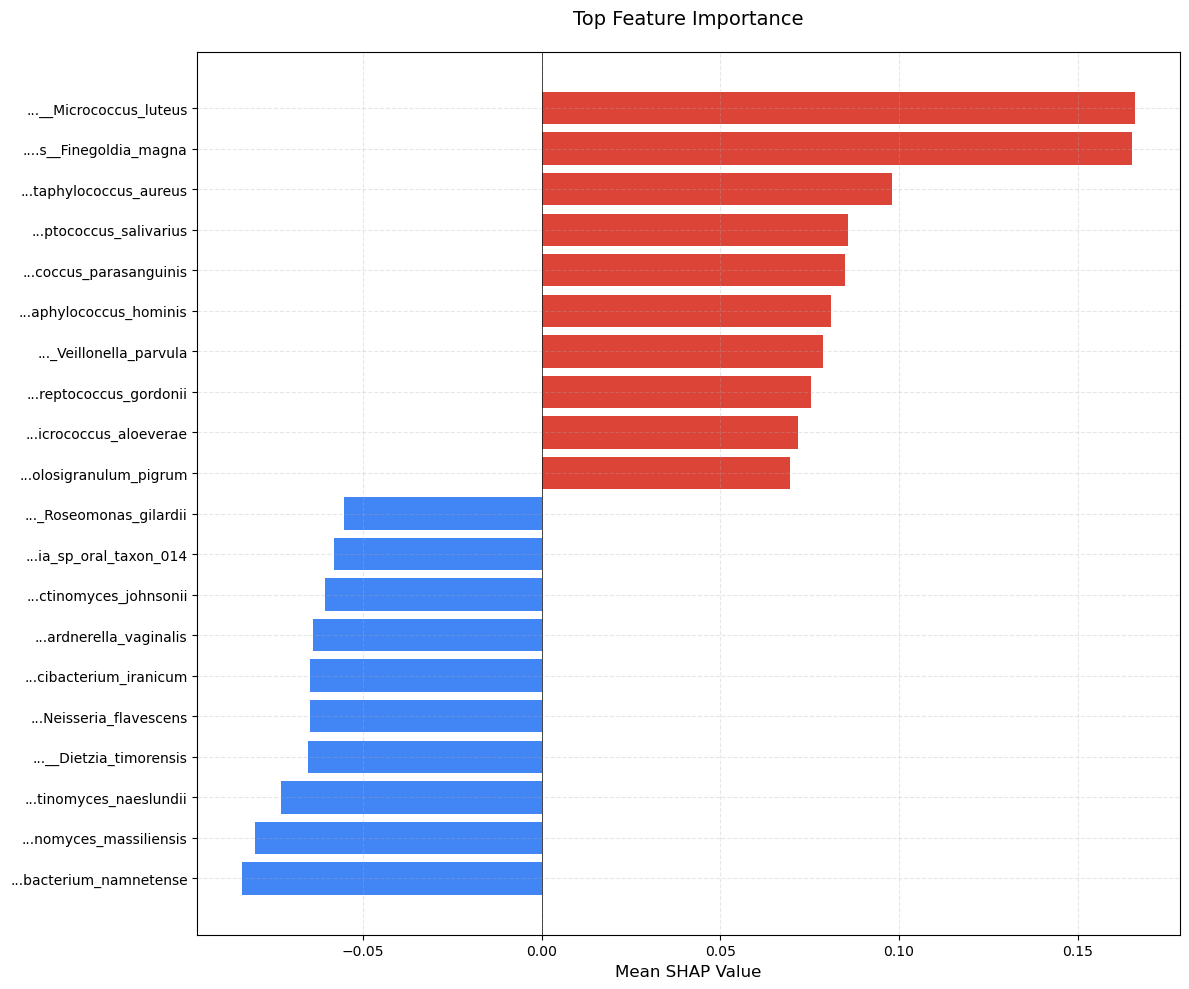

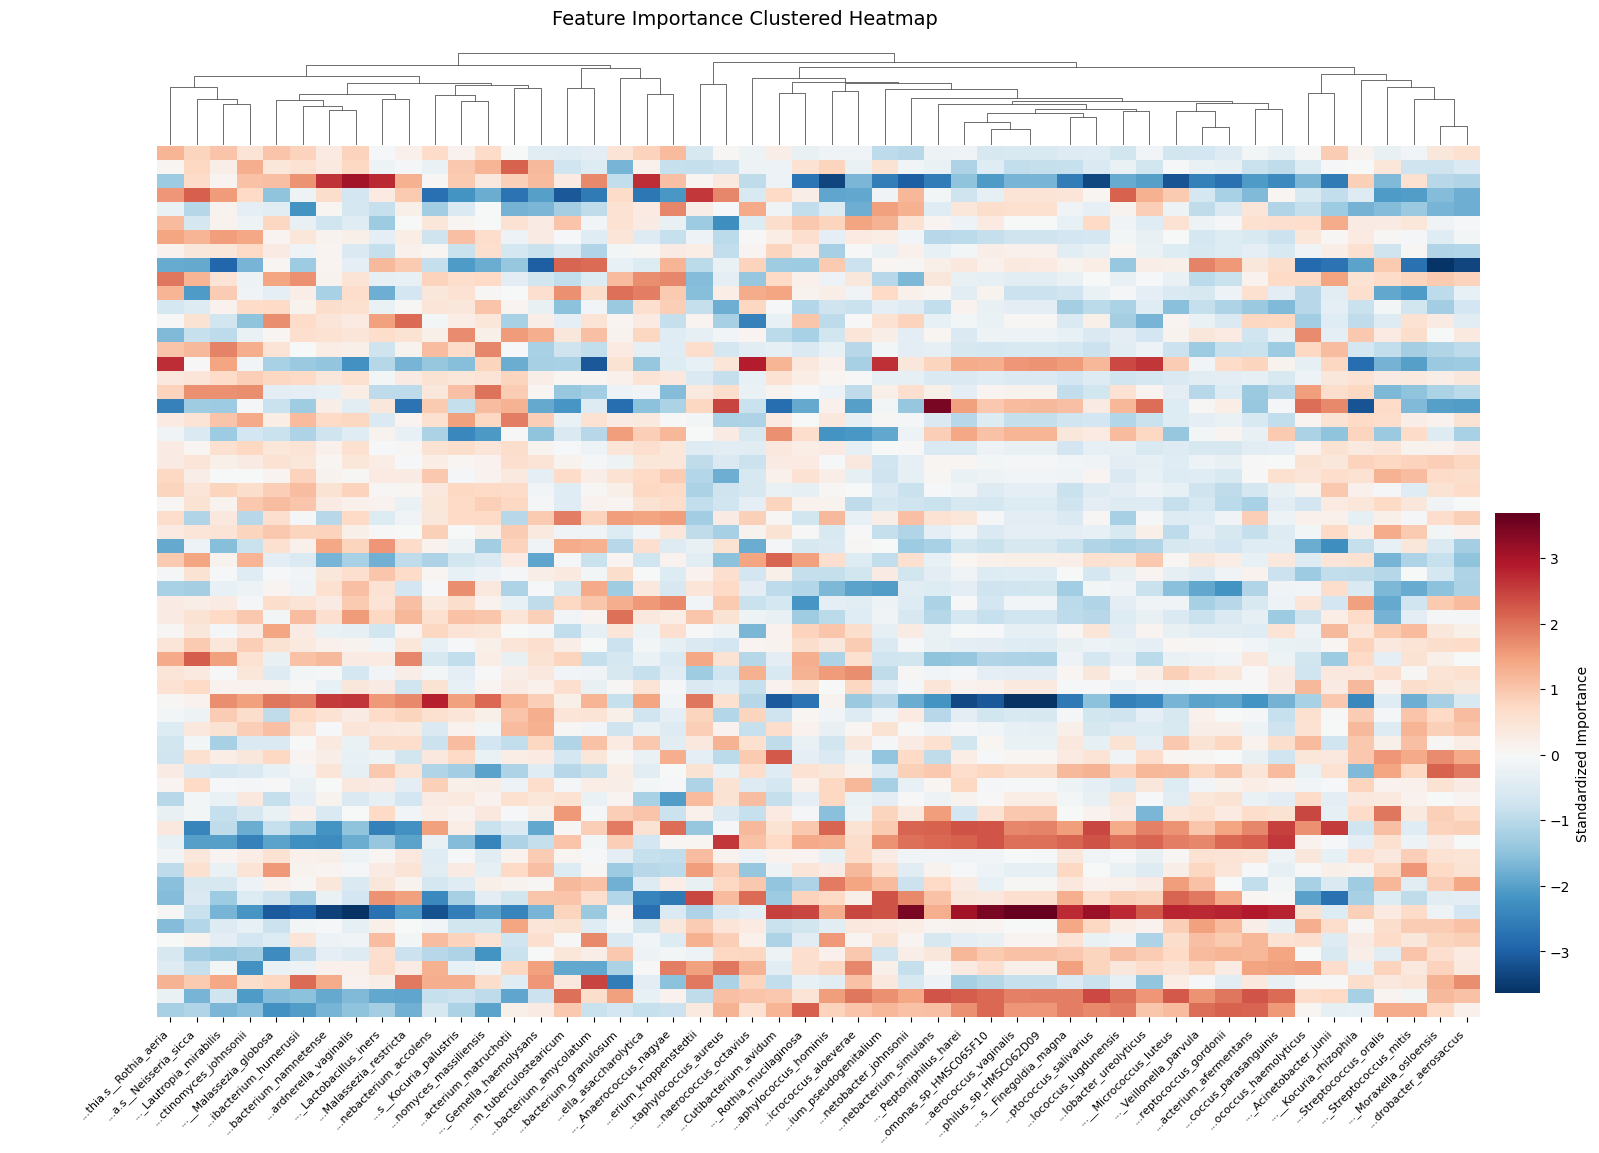

In [4]:
# After preprocessing and training
results = analyze_features(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    pca=pca,
    original_features=df.columns,
    device='mps' if torch.backends.mps.is_available() else 'cpu'
)

# Access results
feature_importance_df = results['feature_importance_df']  # Overall feature importance
sample_importances = results['sample_importance_df']  # Sample-specific importance

# # Save results
# importance_df.to_csv('feature_importance.csv')
# sample_importances.to_csv('sample_importances.csv')

Number of training samples: 55
Number of test samples: 7

Training Support Vector Regression...
Results for Support Vector Regression:
MAE: 14.216
MSE: 351.121
RMSE: 18.738
R2: -0.244

Training Gradient Boosting Regression...
Results for Gradient Boosting Regression:
MAE: 12.707
MSE: 212.547
RMSE: 14.579
R2: 0.247

Training K-Neighbors Regression...
Results for K-Neighbors Regression:
MAE: 13.914
MSE: 269.309
RMSE: 16.411
R2: 0.046

Training Neural Network Regression...
Results for Neural Network Regression:
MAE: 10.020
MSE: 120.969
RMSE: 10.999
R2: 0.571

Training Random Forest Regression...
Results for Random Forest Regression:
MAE: 13.714
MSE: 211.421
RMSE: 14.540
R2: 0.251


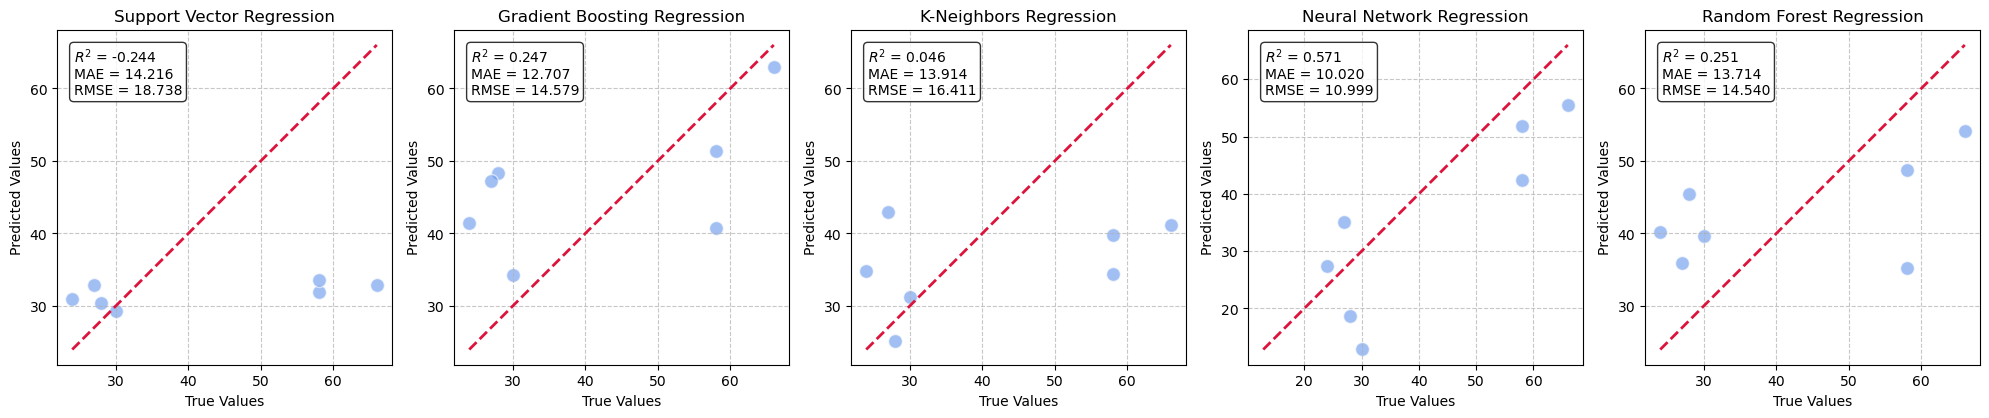

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from torch.utils.data import DataLoader
from TRPCA.utils import clr_transform
from gemelli.preprocessing import matrix_rclr

regressors = {
    "Support Vector Regression": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "Gradient Boosting Regression": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "K-Neighbors Regression": KNeighborsRegressor(n_neighbors=5),
    "Neural Network Regression": MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=2000, random_state=42),
    "Random Forest Regression": RandomForestRegressor(n_estimators=100, random_state=42),
}

def compare_regressors(
    X: pd.DataFrame,
    y: pd.Series,
    train_loader: DataLoader,
    test_loader: DataLoader,
    pca: PCA,
    regressors: Dict,
) -> Tuple[Dict, plt.Figure]:
    """
    Compare different regressors using the same train/test split as the deep learning model
    """
    # Extract original indices from data loaders
    train_indices = train_loader.dataset.original_indices
    test_indices = test_loader.dataset.original_indices
    
    print(f"Number of training samples: {len(train_indices)}")
    print(f"Number of test samples: {len(test_indices)}")
    
    # Convert to numpy array for PCA, dropping feature names
    X_np = X.values
    
    # Get PCA transformed features
    X_pca = pd.DataFrame(
        pca.transform(X_np),
        index=X.index
    )
    
    # Split data using the original indices
    X_train = X_pca.loc[train_indices]
    X_test = X_pca.loc[test_indices]
    y_train = y.loc[train_indices]
    y_test = y.loc[test_indices]
    
    results = {}
    
    # Train and evaluate each regressor
    for name, regressor in regressors.items():
        print(f"\nTraining {name}...")
        
        # Train the model
        regressor.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pd.Series(
            regressor.predict(X_test),
            index=test_indices
        )
        
        # Calculate metrics
        metrics = {
            'mae': mean_absolute_error(y_test, y_pred),
            'mse': mean_squared_error(y_test, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'r2': r2_score(y_test, y_pred)
        }
        
        results[name] = {
            'metrics': metrics,
            'predictions': y_pred,
            'true_values': y_test
        }
        
        print(f"Results for {name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name.upper()}: {value:.3f}")
    
    # Create comparison plot with dynamic grid size
    n_regressors = len(results)
    n_cols = n_regressors
    n_rows = 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 10*n_rows))
    axes = np.array(axes).ravel() if n_regressors > 1 else [axes]
    
    # Hide extra subplots if any
    for idx in range(n_regressors, len(axes)):
        axes[idx].set_visible(False)
    
    for idx, (name, result) in enumerate(results.items()):
        ax = axes[idx]
        
        # Create scatter plot
        ax.scatter(result['true_values'], result['predictions'], 
                  alpha=0.6, 
                  c='cornflowerblue',
                  edgecolor='white',
                  s=100)
        
        # Add perfect prediction line
        min_val = min(result['true_values'].min(), result['predictions'].min())
        max_val = max(result['true_values'].max(), result['predictions'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 
                '--', 
                color='crimson', 
                label='Perfect Prediction',
                linewidth=2)
        
        # Add metrics text
        metrics = result['metrics']
        metrics_text = (f'$R^2$ = {metrics["r2"]:.3f}\n'
                       f'MAE = {metrics["mae"]:.3f}\n'
                       f'RMSE = {metrics["rmse"]:.3f}')
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax.text(0.05, 0.95, metrics_text,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='top',
                bbox=props)
        
        # Customize the plot
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(name)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    
    return results, fig

X_clr = pd.DataFrame(
    matrix_rclr(X+1), 
    columns=X.columns,
    index=X.index
)

# Then run the comparison
results, comparison_plot = compare_regressors(
    X=X_clr,
    y=y,
    train_loader=train_loader,
    test_loader=test_loader,
    pca=pca,
    regressors=regressors
)


### MTL Example

In [6]:
table = load_table('data/skin_1975.biom').to_dataframe(dense=True).T.astype(int)
age_metadata = pd.read_csv('data/skin_1975_map.txt', sep='\t', index_col=0, dtype={'qiita_host_age': float})
age_metadata = age_metadata.drop_duplicates(subset='host_subject_id') #get one sample per subject
age_metadata = age_metadata.loc[age_metadata.qiita_host_sex.notna()]
table = table.loc[age_metadata.index]
columns_to_drop = table.columns[table.apply(lambda col: (col != 0).sum()) < len(table) * 0.05] #drop columns with low prev (5%)
df = table.drop(columns=columns_to_drop).copy()

/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_20574/621710508.py:2: DtypeWarning: Columns (124,384,841,844,968) have mixed types. Specify dtype option on import or set low_memory=False.
  age_metadata = pd.read_csv('data/skin_1975_map.txt', sep='\t', index_col=0, dtype={'qiita_host_age': float})


[I 2025-02-13 13:00:15,505] A new study created in memory with name: no-name-4cf1a49e-7459-4e40-af0b-eb69563cbf44


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-02-13 13:00:38,462] Trial 0 finished with value: 10.15342903137207 and parameters: {'lr': 0.3080301609830422, 'weight_decay': 8.209716622854586e-06}. Best is trial 0 with value: 10.15342903137207.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-02-13 13:01:01,149] Trial 1 finished with value: 9.637069702148438 and parameters: {'lr': 0.28101887578227347, 'weight_decay': 0.12142949438136985}. Best is trial 1 with value: 9.637069702148438.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-02-13 13:01:26,461] Trial 2 finished with value: 18.77731704711914 and parameters: {'lr': 0.0019516731214682596, 'weight_decay': 0.238456235813779}. Best is trial 1 with value: 9.637069702148438.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-02-13 13:01:52,023] Trial 3 finished with value: 9.982898712158203 and parameters: {'lr': 0.13071191554257153, 'weight_decay': 1.3605572798542731e-05}. Best is trial 1 with value: 9.637069702148438.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-02-13 13:02:17,823] Trial 4 finished with value: 7.891058921813965 and parameters: {'lr': 0.08562329051992941, 'weight_decay': 0.03638786863142028}. Best is trial 4 with value: 7.891058921813965.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]


Final Metrics:
Regression MAE: 10.752
Regression R²: 0.206
Classification Accuracy: 0.545


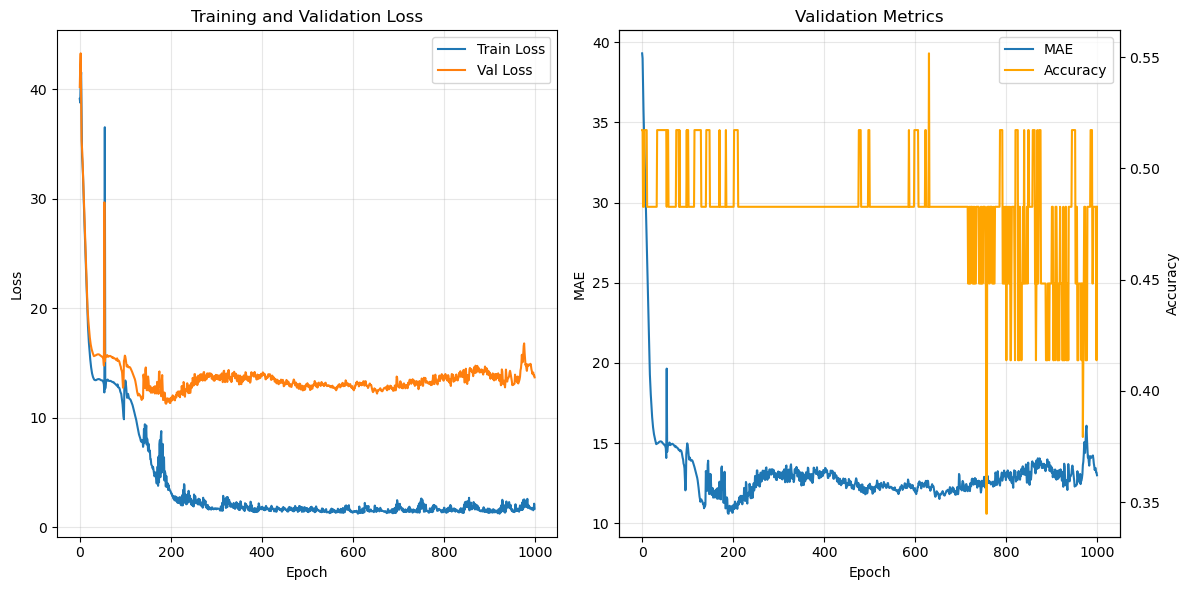

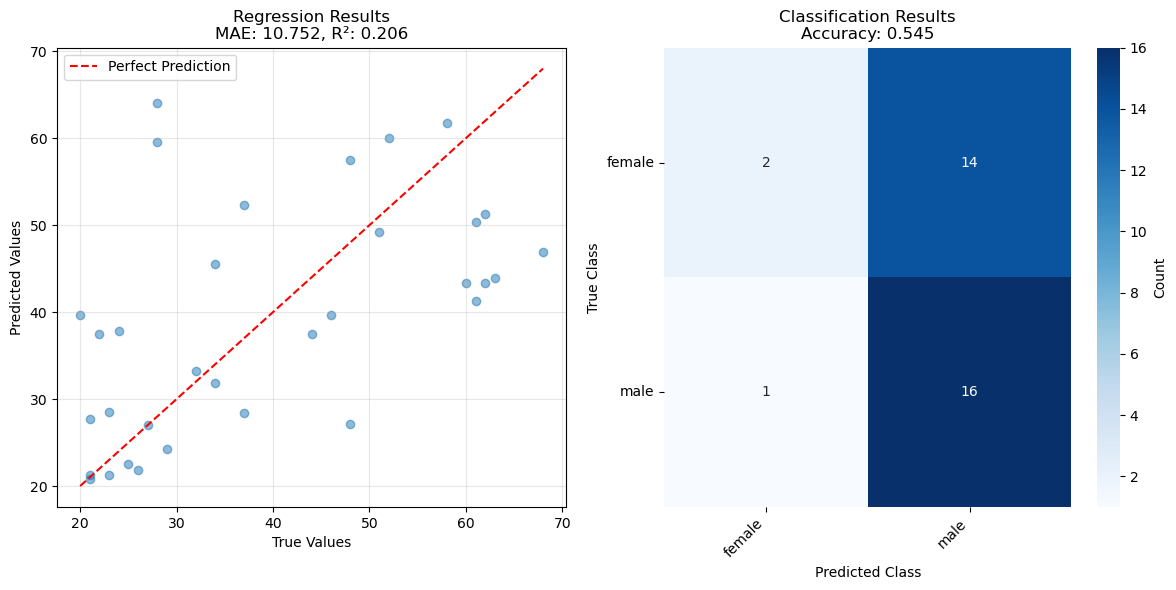

In [8]:
import pandas as pd
import torch
from TRPCA.utils import preprocess_mtl, train_model_mtl, predict_and_evaluate_mtl

# Set up the features (X) and targets (y_reg, y_cls)
X = df  # Your preprocessed feature table
y_reg = age_metadata['qiita_host_age']  # Regression target (e.g., age)
y_cls = age_metadata['qiita_host_sex']  # Classification target (e.g., country)

# Create age bins (4 equal-sized groups using quantiles)
age_bins = pd.qcut(age_metadata['qiita_host_age'], q=4, labels=['young', 'middle', 'old', 'older'])

# Combine gender and age bins into a single stratification column
strata_col = age_metadata['qiita_host_sex'] + '_' + age_bins.astype(str)


# Get number of unique classes for classification
n_classes = y_cls.nunique()

# Define model parameters
model_params = {
    'input_dim': 256,      # Number of PCA components
    'hidden_dim': 256,    # Hidden dimension size
    'num_layers': 1,      # Number of transformer layers
    'num_classes': n_classes,  # Number of classification classes
    'output_dim': 1,      # Regression output dimension
    'projection_dim': 4   # Projection dimension for transformer
}

# Preprocess with your parameters
train_loader, test_loader, pca, label_encoder = preprocess_mtl(
    df=X,
    reg_series=y_reg,
    cls_series=y_cls,
    num_pcs=256,
    test_split=0.1,
    stratify_col=strata_col, # stratify to include even distributions of gender and age group samples
    group_col=age_metadata['host_subject_id'],
    batch_size=1024,
)

# Train with your parameters
model, history, training_fig = train_model_mtl(
    train_loader=train_loader,
    model_params=model_params,
    num_epochs=1000,
    device='mps' if torch.backends.mps.is_available() else 'cpu',
    val_split=0.1,
    use_optuna=True,  # True for parameter fine-tuning
    n_trials=5,       # number of trials to run for optimization
)

# Save training visualization
# training_fig.savefig('training_history.png')

# Evaluate model
metrics, predictions, eval_fig = predict_and_evaluate_mtl(
    model=model,
    test_loader=test_loader,
    label_encoder=label_encoder,  # Pass the label encoder
    device='mps' if torch.backends.mps.is_available() else 'cpu'
)

# Save evaluation visualization
# eval_fig.savefig('evaluation_results.png')

# Print final metrics
print("\nFinal Metrics:")
print(f"Regression MAE: {metrics['mae']:.3f}")
print(f"Regression R²: {metrics['r2']:.3f}")
print(f"Classification Accuracy: {metrics['accuracy']:.3f}")